In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

PROJECT_ROOT       = Path.cwd().parent
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

prior    = pd.read_parquet(PROCESSED_DATA_DIR / "fact_order_items.parquet")
products = pd.read_parquet(PROCESSED_DATA_DIR / "dim_products.parquet")

In [3]:
products.info()

<class 'pandas.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   product_id     49688 non-null  int64
 1   product_name   49688 non-null  str  
 2   aisle_id       49688 non-null  int64
 3   aisle          49688 non-null  str  
 4   department_id  49688 non-null  int64
 5   department     49688 non-null  str  
dtypes: int64(3), str(3)
memory usage: 4.8 MB


In [4]:
prior.info()

<class 'pandas.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 1.0 GB


In [5]:
df = prior.merge(products, on="product_id", how="inner")
df.sample(5)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,aisle,department_id,department
32369214,3414262,21349,5,0,Miniatures,45,candy chocolate,19,snacks
3128744,330299,21903,5,1,Organic Baby Spinach,123,packaged vegetables fruits,4,produce
18240313,1924112,6184,8,1,Clementines,32,packaged produce,4,produce
24869216,2622892,4610,10,1,Country Sourdough Bread,112,bread,3,bakery
4139427,436813,28465,10,1,Icelandic Style Skyr Blueberry Non-fat Yogurt,120,yogurt,16,dairy eggs


In [6]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 9 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
 4   product_name       str  
 5   aisle_id           int64
 6   aisle              str  
 7   department_id      int64
 8   department         str  
dtypes: int64(6), str(3)
memory usage: 3.8 GB


In [7]:
# We only need the order_id and product_id columns for the FP-Growth algorithm, so we will drop the other columns.
df_fp = df[["order_id", "product_id"]]
df_fp.sample(5)

,order_id,product_id
9448987,997408,37103
14796538,1561183,18109
3380527,357090,20995
25080505,2645231,9076
33332267,2215520,24852


In [8]:
df_fp.info()

<class 'pandas.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 2 columns):
 #   Column      Dtype
---  ------      -----
 0   order_id    int64
 1   product_id  int64
dtypes: int64(2)
memory usage: 516.0 MB


In [9]:
# Check for missing values
df_fp.isnull().sum()

order_id      0
product_id    0
dtype: int64

In [10]:
# Check for duplicated rows
print("Number of duplicated rows:", df_fp.duplicated().sum())

Number of duplicated rows: 0


In [11]:
# Check the number of unique orders and products
print(f"Number of unique orders: {df_fp['order_id'].nunique()}")
print(f"Number of unique products: {df_fp['product_id'].nunique()}")

Number of unique orders: 3346083
Number of unique products: 49685


In [12]:
# Save the cleaned DataFrame to a parquet file for later use in the FP-Growth algorithm.
df_fp.to_parquet(
    PROCESSED_DATA_DIR / "transactions.parquet",
    engine="pyarrow",
    compression="snappy",
    index=False
)
# pyarrow is a fast and efficient library for reading and writing parquet files, while snappy is a compression algorithm that provides a good balance between compression ratio and speed. Setting index=False ensures that the DataFrame index is not included in the output file, which can save space and improve performance when reading the file later.

In [13]:
# loading the data which is saved in parquet format
df_fp = pd.read_parquet(PROCESSED_DATA_DIR / "transactions.parquet")

In [14]:
df_fp.info()

<class 'pandas.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 2 columns):
 #   Column      Dtype
---  ------      -----
 0   order_id    int64
 1   product_id  int64
dtypes: int64(2)
memory usage: 516.0 MB


In [15]:
# Calculate basket sizes
basket_sizes = df_fp.groupby('order_id').size()

# Filter for orders with 2 or more products
multi_item_ids = basket_sizes[basket_sizes >= 2].index
df_mining = df_fp[df_fp['order_id'].isin(multi_item_ids)]

# Print metrics
print(f"Baskets with 1 item (Removed): {len(basket_sizes) - len(multi_item_ids):,}")
print(f"Baskets with 2+ items (Retained): {len(multi_item_ids):,}")

Baskets with 1 item (Removed): 163,593
Baskets with 2+ items (Retained): 3,182,490


#### Filtering: Handling "Single-Item" Baskets
- In **Association Rule Mining** (FP-Growth/Apriori), we seek to discover relationships between products. For a relationship to exist, an order must contain at least **two items**. 

- I grouped the data by `order_id` to calculate the "basket size" for every transaction. We then create a mask to retain only the orders that meet our **minimum requirement**.

In [16]:
# Create baskets for FP-Growth

# I group by order_id and turn the product_ids into a list
# This creates the exact format the FP-Growth library expects
baskets = df_mining.groupby('order_id')['product_id'].apply(list).tolist()

print(f"Created {len(baskets):,} baskets.")
print(f"Example of a single basket: {baskets[0]}")

Created 3,182,490 baskets.
Example of a single basket: [49302, 11109, 10246, 49683, 43633, 13176, 47209, 22035]


#### Transactional Baskets
### **Transactional "List of Lists"** format
I am converting the data from a "Tall" format (where each row is one product) to a "Wide" format (where each row is one complete order).

1.  **`groupby('order_id')`**: This identifies all rows belonging to a single shopping trip.
2.  **`['product_id'].apply(list)`**: Within each group, we harvest all the unique product IDs and pack them into a standard Python list.
3.  **`.tolist()`**: We convert the resulting Pandas Series into a master list containing millions of sub-lists (one per order).

In [17]:
# Sort the items within each basket
# This makes the FP-Tree construction much more efficient
baskets = [sorted(basket) for basket in baskets]

print(f"Example of a sorted basket: {baskets[0]}")

Example of a sorted basket: [10246, 11109, 13176, 22035, 43633, 47209, 49302, 49683]


In [18]:
# First, let's see what we're working with. 
# value_counts() gives us the frequency for every product in the dataset.
item_counts = df_mining['product_id'].value_counts()

# Let's see top 10 popular items
# If Bananas are at 15%, that's a huge anchor for our rules.
item_percents = (item_counts / len(baskets)) * 100
print(item_percents.head(10))

# Focus on the Top 2000.
# Why 2000? It covers the high-velocity items and keeps the matrix 
# small enough that my pc can handle it.
TOP_N = 2000
top_2000_set = set(item_counts.head(TOP_N).index)

print(f"\nLocked in the Top {TOP_N} products for the final matrix.")

product_id
24852    15.370512
13176    12.319002
21137     8.622682
21903     7.871227
47209     6.917791
47766     5.771990
47626     5.039670
16797     4.662638
26209     4.598569
27966     4.468985
Name: count, dtype: float64

Locked in the Top 2000 products for the final matrix.


#### Product popularity and Long-Tail Analysis

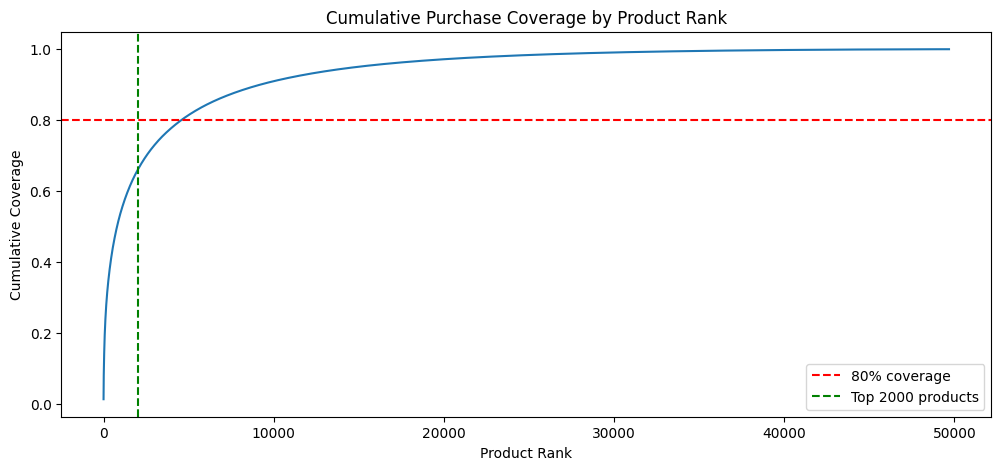

In [19]:
# Long-Tail Analysis of Product Popularity

# Sort product frequencies
sorted_counts = item_counts.sort_values(ascending=False)

# Cumulative coverage
cum_coverage = sorted_counts.cumsum() / sorted_counts.sum()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(cum_coverage.values)
plt.axhline(0.8, linestyle="--", color="red", label="80% coverage")
plt.axvline(2000, linestyle="--", color="green", label="Top 2000 products")
plt.title("Cumulative Purchase Coverage by Product Rank")
plt.xlabel("Product Rank")
plt.ylabel("Cumulative Coverage")
plt.legend()
plt.show()

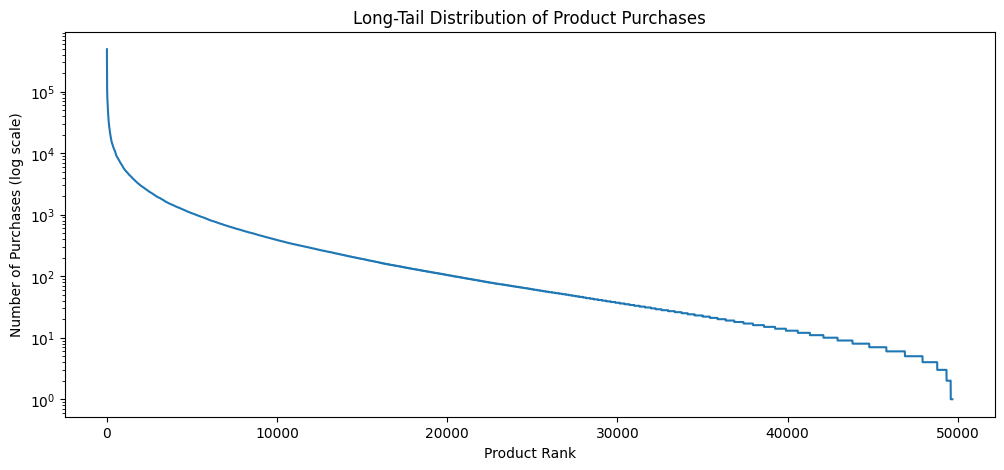

In [20]:
plt.figure(figsize=(12,5))
plt.plot(sorted_counts.values)
plt.yscale("log")
plt.title("Long-Tail Distribution of Product Purchases")
plt.xlabel("Product Rank")
plt.ylabel("Number of Purchases (log scale)")
plt.show()

#### Interpretation
- form the plot graph it is clearly shows that small set of top products accounts for most transactions.
- The log scale distribution graph further confirms the long tail behaviour, a few products have very high purchase counts followed by many low-frequency products.

In [21]:
# Now I need to clean the actual baskets. 
# I'm looping through every order and tossing out anything that isn't a "Top 2000" item.
# Using a set lookup here because doing this 3 million times on a list would take time
# set lookups works like a hash table and are O(1) on average, while list lookups are O(n).
baskets_filtered = [[item for item in b if item in top_2000_set] for b in baskets]

# if I remove items, some baskets might now have only 1 item (or zero).
# I'll drop those now since you can't have an "association" with just one product.
baskets_final = [b for b in baskets_filtered if len(b) >= 2]

print(f"Cleaned up! We have {len(baskets_final):,} baskets left for the algorithm.")

Cleaned up! We have 2,873,040 baskets left for the algorithm.


#### Interpretation
- Based on the long-tail analysis, we retain the top 2000 most frequent products to reduce sparsity while preserving most purchase behavior.
I then removed baskets with fewer than two items since association rules require co-occurrence.
* **Input**: 3,058,126 baskets (unfiltered).
* **Output**: 2,761,063 baskets (optimized).
* **Retention**: Approximately **90.3%** of multi-item baskets were retained after filtering for the Top 2,000 products, indicating that our feature selection covers the vast majority of core consumer behavior.

In [22]:
from mlxtend.preprocessing import TransactionEncoder

# I'm initializing the encoder to turn my list of lists into a True/False matrix.
te = TransactionEncoder()

print("Converting baskets to a sparse matrix.")

# The sparse=True argument is the most important part here. 
# It tells Python to only store the 'True' values, saving massive amounts of RAM.
# how sparse=True works: Instead of storing a full matrix with mostly False values.
te_ary = te.fit(baskets_final).transform(baskets_final, sparse=True)

# I'll wrap this in a Sparse DataFrame so I can keep the product_id column names.
df_encoded = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

print(f"Matrix is ready! Shape: {df_encoded.shape}")
print(f"Approximate RAM usage: {df_encoded.memory_usage().sum() / 1024**2:.2f} MB")

Converting baskets to a sparse matrix.
Matrix is ready! Shape: (2873040, 2000)
Approximate RAM usage: 104.80 MB


#### Sparse Boolean Encoding

- Transforming the baskets into a **Binary Matrix** (One-Hot Encoding). This is the specific mathematical format required by the **FP-Growth** algorithm to calculate item relationships.

### **The "Sparse" Solution** 
- **The Problem**: A "Dense" matrix would store every single `False` value, requiring over **20GB of RAM**.
- **The Solution**: We use `sparse=True`. This tells Python to only remember where the `True` values (the actual purchases) are located. 
- **Preserving Identity**: We wrap the matrix in a **Sparse DataFrame**. This ensures that our column headers remain the original **Product IDs**, allowing us to identify the products later.

In [23]:
from mlxtend.frequent_patterns import fpgrowth

# The fpgrowth library has a bug with Sparse DataFrames when column names are integers.
# I'm converting the Product IDs to strings to bypass this limitation.
df_encoded.columns = [str(i) for i in df_encoded.columns]

# Now we try the mining again.
# I'm sticking with 0.1% (0.001) to see how many "strong" patterns we have.
print("Starting FP-Growth mining with string-based columns")
frequent_itemsets = fpgrowth(df_encoded, min_support=0.001, use_colnames=True)

# Sorting so the most popular itemsets are at the top.
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

print(f"Success Found {len(frequent_itemsets)} frequent itemsets.")
print(frequent_itemsets.head(10))

Starting FP-Growth mining with string-based columns
Success Found 4809 frequent itemsets.
      support            itemsets
45   0.168530  frozenset({24852})
0    0.135132  frozenset({13176})
46   0.095030  frozenset({21137})
10   0.086740  frozenset({21903})
1    0.076289  frozenset({47209})
47   0.063672  frozenset({47766})
148  0.055538  frozenset({47626})
209  0.051118  frozenset({16797})
274  0.050701  frozenset({26209})
21   0.049283  frozenset({27966})


In [24]:
from mlxtend.frequent_patterns import fpgrowth

# The fpgrowth library has a bug with Sparse DataFrames when column names are integers.
# I'm converting the Product IDs to strings to bypass this limitation.
df_encoded.columns = [str(i) for i in df_encoded.columns]

# Now we try the mining again.
# I'm sticking with 0.1% (0.005) to see how many "strong" patterns we have.
print("Starting FP-Growth mining with string-based columns")
frequent_itemsets_005 = fpgrowth(df_encoded, min_support=0.005, use_colnames=True)

# Sorting so the most popular itemsets are at the top.
frequent_itemsets_005 = frequent_itemsets_005.sort_values(by='support', ascending=False)

print(f"Success Found {len(frequent_itemsets_005)} frequent itemsets.")
print(frequent_itemsets.head(10))

Starting FP-Growth mining with string-based columns
Success Found 424 frequent itemsets.
      support            itemsets
45   0.168530  frozenset({24852})
0    0.135132  frozenset({13176})
46   0.095030  frozenset({21137})
10   0.086740  frozenset({21903})
1    0.076289  frozenset({47209})
47   0.063672  frozenset({47766})
148  0.055538  frozenset({47626})
209  0.051118  frozenset({16797})
274  0.050701  frozenset({26209})
21   0.049283  frozenset({27966})


In [25]:
from mlxtend.frequent_patterns import fpgrowth

# The fpgrowth library has a bug with Sparse DataFrames when column names are integers.
# I'm converting the Product IDs to strings to bypass this limitation.
df_encoded.columns = [str(i) for i in df_encoded.columns]

# Now we try the mining again.
# I'm sticking with 0.9% (0.009) to see how many "strong" patterns we have.
print("Starting FP-Growth mining with string-based columns")
frequent_itemsets_009 = fpgrowth(df_encoded, min_support=0.009, use_colnames=True)

# Sorting so the most popular itemsets are at the top.
frequent_itemsets_009 = frequent_itemsets_009.sort_values(by='support', ascending=False)

print(f"Success Found {len(frequent_itemsets_009)} frequent itemsets.")
print(frequent_itemsets.head(10))

Starting FP-Growth mining with string-based columns
Success Found 164 frequent itemsets.
      support            itemsets
45   0.168530  frozenset({24852})
0    0.135132  frozenset({13176})
46   0.095030  frozenset({21137})
10   0.086740  frozenset({21903})
1    0.076289  frozenset({47209})
47   0.063672  frozenset({47766})
148  0.055538  frozenset({47626})
209  0.051118  frozenset({16797})
274  0.050701  frozenset({26209})
21   0.049283  frozenset({27966})


#### FP-Growth Parameter Tuning: Minimum Support
- FP-Growth was executed with progressively increasing minimum support thresholds (0.001, 0.005, 0.009) to balance pattern coverage and interpretability.
- 0.001 → Very large number of itemsets (many weak patterns)
- 0.005 → Moderate reduction in itemsets
- 0.009 → Compact set of strong frequent itemsets (164)
Higher support thresholds reduce spurious associations and improve rule quality.
Thus, min_support = 0.009 was chosen as the optimal setting for final pattern discovery.

In [26]:
from mlxtend.frequent_patterns import association_rules

# We generate the rules based on our frequent itemsets.
# I'm using 'lift' as the metric because it shows how much MORE likely 
# someone is to buy Y given X, compared to just buying Y randomly.
rules = association_rules(frequent_itemsets_009, metric="lift", min_threshold=1)

# Let's sort them by 'lift' to find the strongest, most "surprising" relationships.
rules = rules.sort_values(by='lift', ascending=False)

print(f"Generated {len(rules)} association rules!")
# Showing the top 10 rules with the most important columns
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Generated 44 association rules!
           antecedents         consequents   support  confidence      lift
39  frozenset({47626})  frozenset({26209})  0.010093    0.181733  3.584377
38  frozenset({26209})  frozenset({47626})  0.010093    0.199070  3.584377
25  frozenset({27966})  frozenset({21137})  0.012368    0.250953  2.640772
24  frozenset({21137})  frozenset({27966})  0.012368    0.130145  2.640772
43  frozenset({27966})  frozenset({47209})  0.009332    0.189361  2.482146
42  frozenset({47209})  frozenset({27966})  0.009332    0.122328  2.482146
27  frozenset({28204})  frozenset({24852})  0.012235    0.381505  2.263723
26  frozenset({24852})  frozenset({28204})  0.012235    0.072601  2.263723
18  frozenset({13176})  frozenset({27966})  0.014717    0.108910  2.209885
19  frozenset({27966})  frozenset({13176})  0.014717    0.298626  2.209885


In [27]:
# products already loaded in Cell 0 from dim_products.parquet
id_to_name = dict(zip(products['product_id'].astype(str), products['product_name']))

def get_names(ids_frozenset):
    # Converts the frozenset of ID strings back to a readable string of names
    return ", ".join([id_to_name.get(str(i), "Unknown") for i in ids_frozenset])

# Apply the naming function to our rules
rules['antecedents_names'] = rules['antecedents'].apply(get_names)
rules['consequents_names'] = rules['consequents'].apply(get_names)

# Display the Final Result
final_report = rules[['antecedents_names', 'consequents_names', 'support', 'confidence', 'lift']]
print("THE FINAL ASSOCIATION RULES")
print(final_report.head(10))

THE FINAL ASSOCIATION RULES
         antecedents_names       consequents_names   support  confidence  \
39             Large Lemon                   Limes  0.010093    0.181733   
38                   Limes             Large Lemon  0.010093    0.199070   
25     Organic Raspberries    Organic Strawberries  0.012368    0.250953   
24    Organic Strawberries     Organic Raspberries  0.012368    0.130145   
43     Organic Raspberries    Organic Hass Avocado  0.009332    0.189361   
42    Organic Hass Avocado     Organic Raspberries  0.009332    0.122328   
27      Organic Fuji Apple                  Banana  0.012235    0.381505   
26                  Banana      Organic Fuji Apple  0.012235    0.072601   
18  Bag of Organic Bananas     Organic Raspberries  0.014717    0.108910   
19     Organic Raspberries  Bag of Organic Bananas  0.014717    0.298626   

        lift  
39  3.584377  
38  3.584377  
25  2.640772  
24  2.640772  
43  2.482146  
42  2.482146  
27  2.263723  
26  2.263723  


In [28]:
# I am removing symmetric duplicate rules (A→B and B→A)
# Keeping only the strongest direction (highest lift)

rules_unique = rules.copy()

# Create unordered pair identifier
rules_unique["pair"] = rules_unique.apply(
    lambda r: tuple(sorted([r["antecedents_names"], r["consequents_names"]])),
    axis=1
)

# Keep strongest rule per pair
rules_unique = (
    rules_unique
    .sort_values("lift", ascending=False)
    .drop_duplicates("pair")
    .drop(columns="pair")
)

print(f"Unique directional rules: {len(rules_unique)}")
rules_unique.head(10)

Unique directional rules: 22


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_names,consequents_names
39,frozenset({47626}),frozenset({26209}),0.055538,0.050701,0.010093,0.181733,3.584377,1.0,0.007277,1.160133,0.763410,0.104977,0.138030,0.190402,Large Lemon,Limes
25,frozenset({27966}),frozenset({21137}),0.049283,0.095030,0.012368,0.250953,2.640772,1.0,0.007684,1.208162,0.653531,0.093734,0.172296,0.190549,Organic Raspberries,Organic Strawberries
43,frozenset({27966}),frozenset({47209}),0.049283,0.076289,0.009332,0.189361,2.482146,1.0,0.005573,1.139485,0.628076,0.080285,0.122410,0.155844,Organic Raspberries,Organic Hass Avocado
27,frozenset({28204}),frozenset({24852}),0.032072,0.168530,0.012235,0.381505,2.263723,1.0,0.006830,1.344344,0.576747,0.064956,0.256143,0.227053,Organic Fuji Apple,Banana
18,frozenset({13176}),frozenset({27966}),0.135132,0.049283,0.014717,0.108910,2.209885,1.0,0.008057,1.066914,0.633030,0.086726,0.062718,0.203768,Bag of Organic Bananas,Organic Raspberries
0,frozenset({13176}),frozenset({47209}),0.135132,0.076289,0.022541,0.166807,2.186509,1.0,0.012232,1.108640,0.627436,0.119340,0.097994,0.231137,Bag of Organic Bananas,Organic Hass Avocado
36,frozenset({24852}),frozenset({45066}),0.168530,0.028846,0.010316,0.061213,2.122087,1.0,0.005455,1.034478,0.635941,0.055150,0.033329,0.209424,Banana,Honeycrisp Apple
35,frozenset({21903}),frozenset({47766}),0.086740,0.063672,0.011239,0.129574,2.035044,1.0,0.005716,1.075713,0.556917,0.080758,0.070384,0.153047,Organic Baby Spinach,Organic Avocado
16,frozenset({47209}),frozenset({21137}),0.076289,0.095030,0.014735,0.193141,2.032412,1.0,0.007485,1.121596,0.549927,0.094099,0.108413,0.174096,Organic Hass Avocado,Organic Strawberries
31,frozenset({49683}),frozenset({24852}),0.034517,0.168530,0.011430,0.331149,1.964925,1.0,0.005613,1.243131,0.508631,0.059652,0.195580,0.199486,Cucumber Kirby,Banana


In [29]:
# Final Top Association Rules (No duplicates)


top_rules = (
    rules_unique
    .sort_values("lift", ascending=False)
    .head(22)
)

print("THE FINAL ASSOCIATION RULES")
top_rules[[
    "antecedents_names",
    "consequents_names",
    "support",
    "confidence",
    "lift"
]]

THE FINAL ASSOCIATION RULES


,antecedents_names,consequents_names,support,confidence,lift
39,Large Lemon,Limes,0.010093,0.181733,3.584377
25,Organic Raspberries,Organic Strawberries,0.012368,0.250953,2.640772
43,Organic Raspberries,Organic Hass Avocado,0.009332,0.189361,2.482146
27,Organic Fuji Apple,Banana,0.012235,0.381505,2.263723
18,Bag of Organic Bananas,Organic Raspberries,0.014717,0.108910,2.209885
0,Bag of Organic Bananas,Organic Hass Avocado,0.022541,0.166807,2.186509
36,Banana,Honeycrisp Apple,0.010316,0.061213,2.122087
35,Organic Baby Spinach,Organic Avocado,0.011239,0.129574,2.035044
16,Organic Hass Avocado,Organic Strawberries,0.014735,0.193141,2.032412
31,Cucumber Kirby,Banana,0.011430,0.331149,1.964925


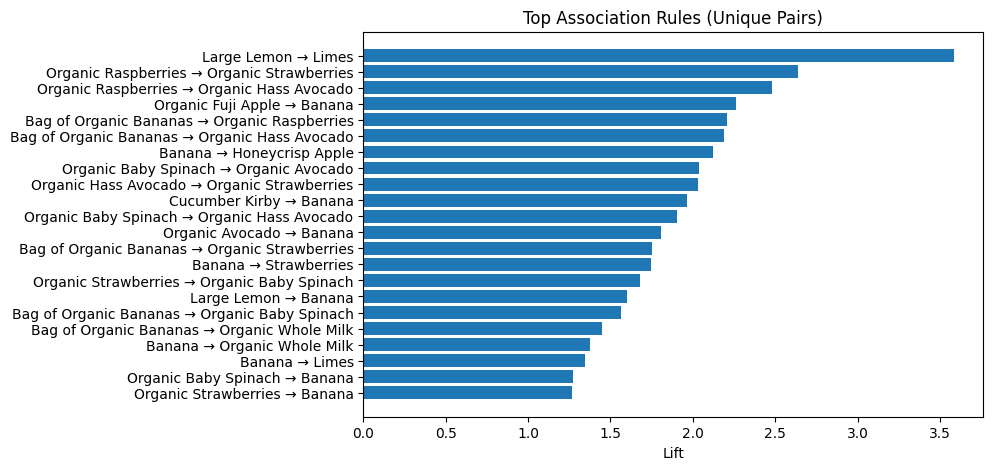

In [30]:
import matplotlib.pyplot as plt

plot_df = top_rules.copy()
plot_df["rule"] = plot_df["antecedents_names"] + " → " + plot_df["consequents_names"]

plt.figure(figsize=(8,5))
plt.barh(plot_df["rule"], plot_df["lift"])
plt.xlabel("Lift")
plt.title("Top Association Rules (Unique Pairs)")
plt.gca().invert_yaxis()
plt.show()

In [31]:
final_report.to_csv(PROCESSED_DATA_DIR / "association_rules_fp_0.csv", index=False)
print("Association rules saved to processed/")

Association rules saved to processed/


## APRIORI

#### Association Rule Mining (Apriori)

- To validate pattern robustness, I applied the Apriori algorithm on the same transaction matrix used for FP-Growth. This provides a comparable set of frequent itemsets and association rules using a candidate-generation approach.

In [34]:
# Apriori scalability: restrict to top-2000 frequent products

print("Selecting top 2000 frequent products for Apriori")

top2000_products = (
    df_encoded.sum()
    .sort_values(ascending=False)
    .head(2000)
    .index
)

df_encoded_top2000 = df_encoded[top2000_products]

print("Original matrix:", df_encoded.shape)
print("Top-2000 matrix:", df_encoded_top2000.shape)

Selecting top 2000 frequent products for Apriori
Original matrix: (2873040, 2000)
Top-2000 matrix: (2873040, 2000)


In [35]:
from mlxtend.frequent_patterns import apriori

print("Running Apriori on top-2000 products (min_support=0.007)")

frequent_itemsets_ap = apriori(
    df_encoded_top2000,
    min_support=0.007,
    use_colnames=True
)

frequent_itemsets_ap = frequent_itemsets_ap.sort_values(
    by="support",
    ascending=False
)

print("Frequent itemsets (Apriori):", len(frequent_itemsets_ap))
frequent_itemsets_ap.head(10)

Running Apriori on top-2000 products (min_support=0.007)
Frequent itemsets (Apriori): 249


,support,itemsets
167,0.168530,frozenset({24852})
182,0.135132,frozenset({13176})
150,0.095030,frozenset({21137})
152,0.086740,frozenset({21903})
67,0.076289,frozenset({47209})
73,0.063672,frozenset({47766})
72,0.055538,frozenset({47626})
191,0.051118,frozenset({16797})
31,0.050701,frozenset({26209})
46,0.049283,frozenset({27966})


In [36]:
from mlxtend.frequent_patterns import association_rules

# generating the rules based on the frequent itemsets from apriori.
rules_ap = association_rules(
    frequent_itemsets_ap,
    metric="lift",
    min_threshold=1
)

rules_ap = rules_ap.sort_values(
    by="lift",
    ascending=False
)

print("Apriori rules:", len(rules_ap))
rules_ap.head(10)

Apriori rules: 96


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
71,frozenset({24964}),frozenset({22935}),0.039501,0.040787,0.007979,0.201988,4.952290,1.0,0.006368,1.202003,0.830894,0.110341,0.168056,0.198803
70,frozenset({22935}),frozenset({24964}),0.040787,0.039501,0.007979,0.195619,4.952290,1.0,0.006368,1.194085,0.832008,0.110341,0.162538,0.198803
38,frozenset({26209}),frozenset({47626}),0.050701,0.055538,0.010093,0.199070,3.584377,1.0,0.007277,1.179207,0.759520,0.104977,0.151972,0.190402
39,frozenset({47626}),frozenset({26209}),0.055538,0.050701,0.010093,0.181733,3.584377,1.0,0.007277,1.160133,0.763410,0.104977,0.138030,0.190402
79,frozenset({5876}),frozenset({47209}),0.031551,0.076289,0.007667,0.243000,3.185250,1.0,0.005260,1.220226,0.708403,0.076536,0.180480,0.171748
78,frozenset({47209}),frozenset({5876}),0.076289,0.031551,0.007667,0.100496,3.185250,1.0,0.005260,1.076649,0.742714,0.076536,0.071192,0.171748
25,frozenset({27966}),frozenset({21137}),0.049283,0.095030,0.012368,0.250953,2.640772,1.0,0.007684,1.208162,0.653531,0.093734,0.172296,0.190549
24,frozenset({21137}),frozenset({27966}),0.095030,0.049283,0.012368,0.130145,2.640772,1.0,0.007684,1.092960,0.686568,0.093734,0.085054,0.190549
53,frozenset({21137}),frozenset({39275}),0.095030,0.036043,0.008710,0.091658,2.542991,1.0,0.005285,1.061226,0.670478,0.071184,0.057694,0.166660
52,frozenset({39275}),frozenset({21137}),0.036043,0.095030,0.008710,0.241661,2.542991,1.0,0.005285,1.193358,0.629450,0.071184,0.162029,0.166660


In [37]:
# Map the product IDs back to names for the Apriori rules
rules_ap["antecedents_names"] = rules_ap["antecedents"].apply(get_names)
rules_ap["consequents_names"] = rules_ap["consequents"].apply(get_names)

In [40]:
# Remove symmetric duplicates from Apriori rules
rules_ap_unique = rules_ap.copy()

rules_ap_unique["pair"] = rules_ap_unique.apply(
    lambda r: tuple(sorted([r["antecedents_names"], r["consequents_names"]])),
    axis=1
)

# Keep strongest rule per pair
rules_ap_unique = (
    rules_ap_unique
    .sort_values("lift", ascending=False)
    .drop_duplicates("pair")
    .drop(columns="pair")
)

print("Unique Apriori rules:", len(rules_ap_unique))
rules_ap_unique.head()

Unique Apriori rules: 48


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_names,consequents_names
71,frozenset({24964}),frozenset({22935}),0.039501,0.040787,0.007979,0.201988,4.952290,1.0,0.006368,1.202003,0.830894,0.110341,0.168056,0.198803,Organic Garlic,Organic Yellow Onion
38,frozenset({26209}),frozenset({47626}),0.050701,0.055538,0.010093,0.199070,3.584377,1.0,0.007277,1.179207,0.759520,0.104977,0.151972,0.190402,Limes,Large Lemon
79,frozenset({5876}),frozenset({47209}),0.031551,0.076289,0.007667,0.243000,3.185250,1.0,0.005260,1.220226,0.708403,0.076536,0.180480,0.171748,Organic Lemon,Organic Hass Avocado
25,frozenset({27966}),frozenset({21137}),0.049283,0.095030,0.012368,0.250953,2.640772,1.0,0.007684,1.208162,0.653531,0.093734,0.172296,0.190549,Organic Raspberries,Organic Strawberries
53,frozenset({21137}),frozenset({39275}),0.095030,0.036043,0.008710,0.091658,2.542991,1.0,0.005285,1.061226,0.670478,0.071184,0.057694,0.166660,Organic Strawberries,Organic Blueberries


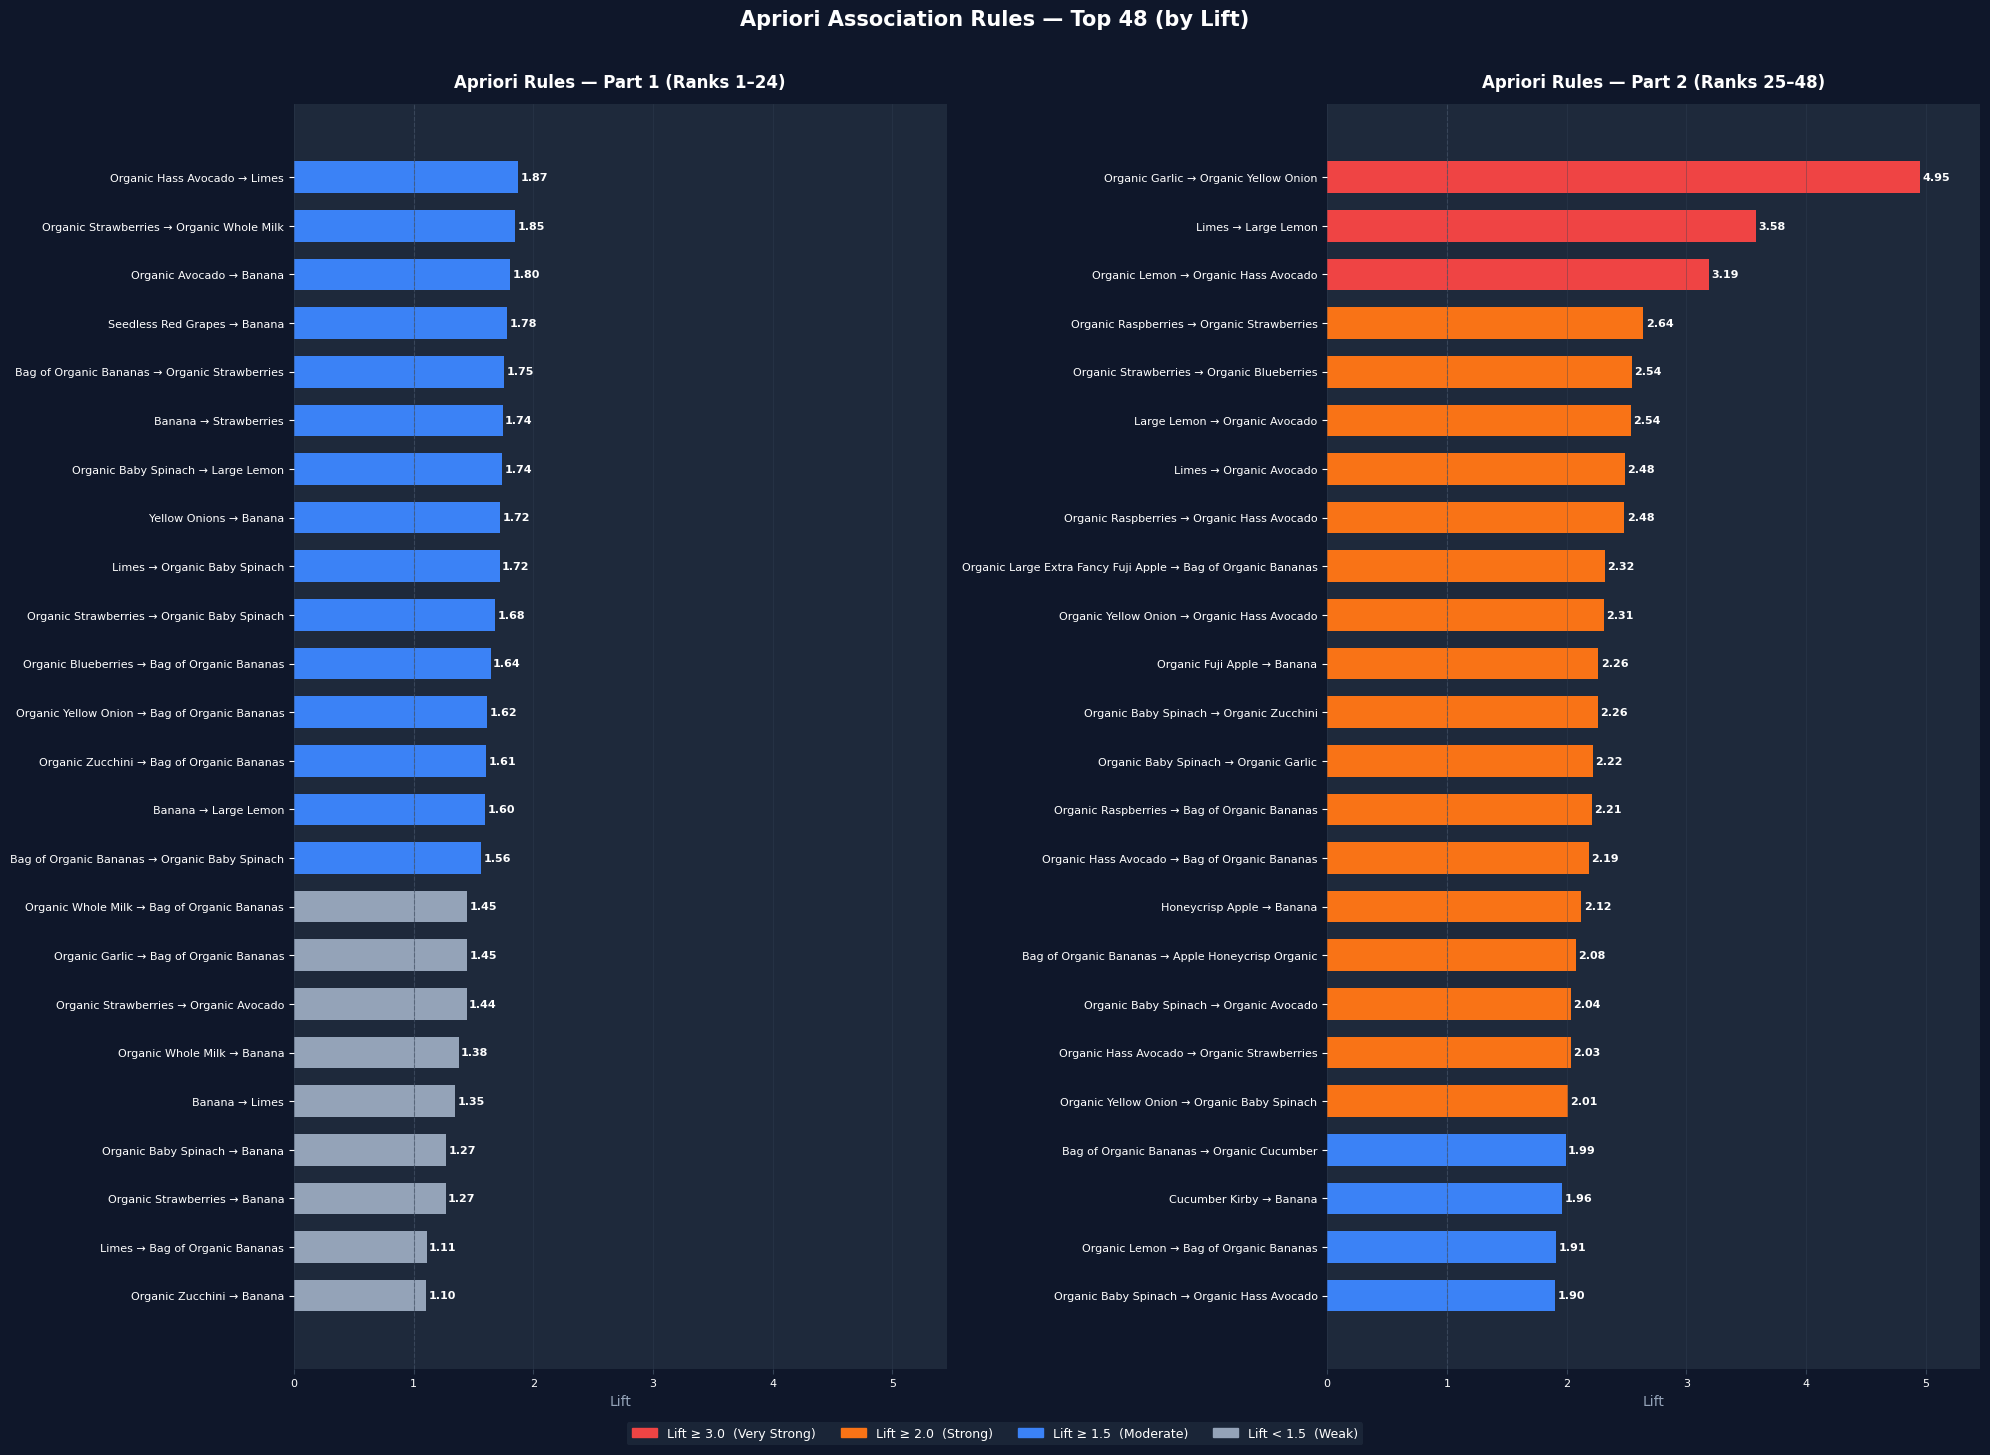

Chart saved to processed/


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

plot_df_ap = rules_ap_unique.head(48).copy()
plot_df_ap["rule"] = (
    plot_df_ap["antecedents_names"] + " → " + plot_df_ap["consequents_names"]
)
plot_df_ap = plot_df_ap.sort_values("lift", ascending=True)

# Color by lift strength
def lift_color(val):
    if val >= 3:   return "#ef4444"   # red   — very strong
    elif val >= 2: return "#f97316"   # orange — strong
    elif val >= 1.5: return "#3b82f6" # blue  — moderate
    else:          return "#94a3b8"   # grey  — weak

colors = plot_df_ap["lift"].apply(lift_color).tolist()

# Split into 2 panels of 24 rules each 
fig, axes = plt.subplots(1, 2, figsize=(20, 14))
fig.patch.set_facecolor("#0f172a")

splits = [plot_df_ap.iloc[:24], plot_df_ap.iloc[24:]]
titles = ["Apriori Rules — Part 1 (Ranks 1–24)", "Apriori Rules — Part 2 (Ranks 25–48)"]

for ax, subset, title in zip(axes, splits, titles):
    subset_colors = subset["lift"].apply(lift_color).tolist()

    bars = ax.barh(
        subset["rule"],
        subset["lift"],
        color=subset_colors,
        edgecolor="none",
        height=0.65
    )

    # Lift value labels on bars
    for bar, val in zip(bars, subset["lift"]):
        ax.text(
            bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2,
            f"{val:.2f}",
            va="center", ha="left",
            fontsize=8, color="white", fontweight="bold"
        )

    ax.set_facecolor("#1e293b")
    ax.set_title(title, color="white", fontsize=12, fontweight="bold", pad=12)
    ax.set_xlabel("Lift", color="#94a3b8", fontsize=10)
    ax.tick_params(colors="white", labelsize=8)
    ax.xaxis.label.set_color("#94a3b8")
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.xaxis.set_tick_params(color="#334155")
    ax.set_xlim(0, plot_df_ap["lift"].max() + 0.5)
    ax.axvline(1.0, color="#475569", linewidth=0.8, linestyle="--", alpha=0.6)
    ax.grid(axis="x", color="#334155", linewidth=0.5, alpha=0.5)

# Legend
legend_patches = [
    mpatches.Patch(color="#ef4444", label="Lift ≥ 3.0  (Very Strong)"),
    mpatches.Patch(color="#f97316", label="Lift ≥ 2.0  (Strong)"),
    mpatches.Patch(color="#3b82f6", label="Lift ≥ 1.5  (Moderate)"),
    mpatches.Patch(color="#94a3b8", label="Lift < 1.5  (Weak)"),
]
fig.legend(
    handles=legend_patches,
    loc="lower center", ncol=4,
    facecolor="#1e293b", edgecolor="none",
    labelcolor="white", fontsize=9,
    bbox_to_anchor=(0.5, -0.02)
)

fig.suptitle(
    "Apriori Association Rules — Top 48 (by Lift)",
    color="white", fontsize=15, fontweight="bold", y=1.01
)

plt.tight_layout()
plt.savefig(PROCESSED_DATA_DIR / "apriori_rules_visual.png", dpi=150,
            bbox_inches="tight", facecolor="#0f172a")
plt.show()
print("Chart saved to processed/")